In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score,GridSearchCV
from skimage.feature import hog
from keras.utils import to_categorical
from keras.models import Sequential, load_model,Model
from imutils import paths
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from tensorflow import keras
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import pickle
import random
import pylab as pl
import scipy.ndimage
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_root='/content/drive/My Drive/ML_Dataset'

In [4]:
BATCH_SIZE=2048
LEARNING_RATE=0.0001

create train and validation sets

In [5]:
IMAGE_SHAPE = (32,32)

TRAINING_DATA_DIR = str(data_root)

print(TRAINING_DATA_DIR);

datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                    subset="validation",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                    subset="training",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    target_size=IMAGE_SHAPE)

/content/drive/My Drive/ML_Dataset
Found 2278 images belonging to 8 classes.
Found 9115 images belonging to 8 classes.


svm part

In [6]:
X_train, y_train = next(train_generator)

In [7]:
xtrain,xtest,ytrain,ytest=train_test_split(X_train,y_train,test_size=0.25)

In [17]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=xtrain.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.05))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.05))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.05))
model.add(Dense(8, activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        36928     
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
epochs = 25
history = model.fit(xtrain, ytrain, batch_size=8, epochs=epochs, validation_data=(xtest, ytest))

Epoch 1/25
192/192 [==============================] - 9s 6ms/step - loss: 1.9385 - accuracy: 0.2233 - val_loss: 1.8421 - val_accuracy: 0.2539
Epoch 2/25
192/192 [==============================] - 1s 4ms/step - loss: 1.8091 - accuracy: 0.2786 - val_loss: 1.7246 - val_accuracy: 0.3398
Epoch 3/25
192/192 [==============================] - 1s 5ms/step - loss: 1.5563 - accuracy: 0.4076 - val_loss: 1.1693 - val_accuracy: 0.6562
Epoch 4/25
192/192 [==============================] - 1s 5ms/step - loss: 0.8923 - accuracy: 0.7044 - val_loss: 0.4715 - val_accuracy: 0.8691
Epoch 5/25
192/192 [==============================] - 1s 5ms/step - loss: 0.4733 - accuracy: 0.8438 - val_loss: 0.3200 - val_accuracy: 0.9102
Epoch 6/25
192/192 [==============================] - 1s 5ms/step - loss: 0.2697 - accuracy: 0.9193 - val_loss: 0.2216 - val_accuracy: 0.9336
Epoch 7/25
192/192 [==============================] - 1s 5ms/step - loss: 0.1894 - accuracy: 0.9368 - val_loss: 0.1822 - val_accuracy: 0.9434
Epoch 

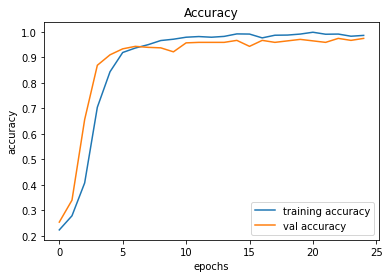

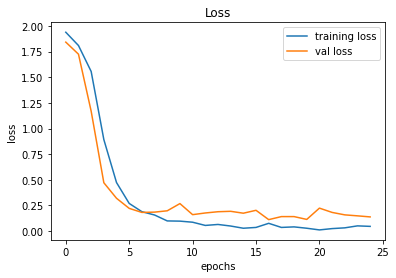

In [10]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
test_predictions = model.predict(xtest) 
test_predictions = np.argmax(test_predictions, axis=1)
y_test = np.argmax(ytest, axis=1)

16/16 [==============================] - 1s 4ms/step


In [12]:
test_result = pd.DataFrame({'y_act': y_test, 'y_pred':test_predictions})
test_result.sample(5)

,y_act,y_pred
32,5,5
471,1,1
445,6,6
35,5,3
451,5,5


In [13]:
cfm = pd.crosstab(test_result['y_act'], test_result['y_pred'], margins=True)
cfm

y_pred,0,1,2,3,4,5,6,7,All
y_act,,,,,,,,,
0,6,0,0,0,0,0,0,1,7
1,0,88,2,0,0,0,0,0,90
2,0,0,84,0,0,0,0,0,84
3,0,0,0,68,0,2,0,1,71
4,0,0,0,0,84,0,0,0,84
5,0,0,0,3,0,54,0,1,58
6,0,0,0,0,0,1,59,0,60
7,0,0,0,0,1,1,0,56,58
All,6,88,86,71,85,58,59,59,512


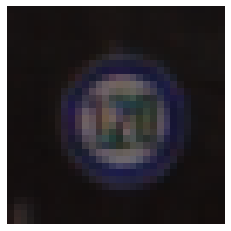

1/1 [==============================] - 0s 23ms/step
True label: 8
Predicted label: 8


In [16]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 32, 32, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))